# Wheat Disease Detection

### 1.1 Introduction

In this ipython notebook, we would be using various neural network models such as VGG19, Xception and InceptionV3 networks to train our wheat dataset. Implementing these networks using pre-trained weights for "imagenet" is very handy, especially for our computer vision problem of detecting diseases in wheat plants. 

In the first few cells, let us import and load the libraries that are important for predicting the changes of a wheat plant to suffer from a disease. Later, preprocessing of the image along with making them compatible with Keras would be done to ensure smooth pipeline. Finally, the networks mentioned above would be used for predicting whether the wheat in an image is healthy or diseased. 

### 1.2 Metrics

1. Categorical Cross Entropy
2. Accuracy 

### 1.3 Source 

The data was downloaded from https://drive.google.com/drive/folders/1OHKtwD1UrdmhqxrpQEeF_X_pqKotxRGD. 

It contains 4 folders with the name of the folder being the class. In each folder, there are quite a large number of wheat images and their condition. The following are the 4 classes which we would consider. 

1. Leaf Rust
2. Crown and Root Rot
3. Healthy Wheat
4. Wheat Loose Smut

The total number of images that we have taken into consideration are 4500 respectively. We would take about 20 percent of the points for testing using stratified sampling which you could see later in the notebook. 

### Table of Contents 

&emsp; 1.1 Introduction

&emsp; 1.2 Metrics

&emsp; 1.3 Source




### Importing Libraries

Below are some of the libraries that we are going to use for our deep learning application. These libraries make the task of training convolutional networks easy and straight-forward. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
import cv2
import os 
import pickle
from imutils import paths
from tqdm import tqdm
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import Xception, ResNet152, InceptionV3, NASNetLarge
%matplotlib inline

In [2]:
LABELS = set(["Crown and Root Rot", "Healthy Wheat", "Leaf Rust", "Wheat Loose Smut"])

### Exploring the images and their paths

In [3]:
count = 0 
for images in paths.list_images('Images/Crown and Root Rot/'):
    print(images)
    count = count + 1
    if count == 5:
        break

Images/Crown and Root Rot/00041.jpg
Images/Crown and Root Rot/00051.jpg
Images/Crown and Root Rot/00061.jpg
Images/Crown and Root Rot/00071.jpg
Images/Crown and Root Rot/00081.png


In [4]:
image = cv2.imread('Images/Crown and Root Rot/00041.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))

Taking a look at the paths where the images are present so that they could be read later using opencv. 

In [5]:
count = 0
for images in paths.list_images('Images/Crown and Root Rot/'):
    print(images)
    count = count + 1
    if count == 5:
        break

Images/Crown and Root Rot/00041.jpg
Images/Crown and Root Rot/00051.jpg
Images/Crown and Root Rot/00061.jpg
Images/Crown and Root Rot/00071.jpg
Images/Crown and Root Rot/00081.png


We find a way to get the name of the image to be used from paths.

In [6]:
sample_path = list(paths.list_images('Images/Crown and Root Rot/'))[0]

In [7]:
sample_path

'Images/Crown and Root Rot/00041.jpg'

Let us now split the path to get our desired result of the image. 

In [8]:
sample_path.split('/')

['Images', 'Crown and Root Rot', '00041.jpg']

When taking a look at the directory, we see the following files as shown below. 

In [9]:
os.listdir()

['.git',
 '.gitattributes',
 '.ipynb_checkpoints',
 'Images',
 'README.md',
 'Wheat Disease Detection.ipynb']

In [10]:
Labels = os.listdir('Images')

In [11]:
print(Labels)

['Crown and Root Rot', 'Healthy Wheat', 'Leaf Rust', 'Wheat Loose Smut']


In [12]:
CROWN_AND_ROOT_ROT_PATH = 'Images/Crown and Root Rot/'
HEALTHY_AND_WHEAT_PATH = 'Images/Healthy Wheat/'
LEAF_RUST_PATH = 'Images/Leaf Rust/'
WHEAT_LOOSE_SMUT_PATH = 'Images/Wheat Loose Smut/'

In [13]:
data = []
labels = []
for image_path in tqdm(paths.list_images(CROWN_AND_ROOT_ROT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    
for image_path in tqdm(paths.list_images(HEALTHY_AND_WHEAT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)

for image_path in tqdm(paths.list_images(LEAF_RUST_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    
for image_path in tqdm(paths.list_images(WHEAT_LOOSE_SMUT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    
    

1021it [00:04, 248.20it/s]
1146it [00:21, 53.18it/s] 
1286it [01:26, 14.93it/s] 
930it [00:04, 204.97it/s]


In [14]:
labels[-1]

'Wheat Loose Smut'

# Transfer Learning

Transfer learning is a method in deep learning where a model that is developed for a particular task is reused as the starting point for our model so that we get it for our use cases. 

In the below cells, transfer learning is applied which ensures that models are not trained from the start. Instead only the last few layers for our application are trained. This leads to a good reduction in the time taken to train them. Furthermore, this leads to a good improvement in the accuracy of the model as state-of-the-art models are taken for training the models. 

## VGG19 Network

VGG19 nework trained on imagenet weights is taken as our base model. In addition to this network, we add more layers so that the final model is used for our task of detecting and identifying wheat diseases. 

In [15]:
headmodel = VGG19(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (224, 224, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.2)(model)
model = Dense(len(Labels), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False

In [16]:
opt = Adam(lr = 1e-3)
final_model.compile(loss = "categorical_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

In [17]:
data = np.array(data)
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)


In [18]:
labels[0]

array([1, 0, 0, 0])

In [19]:
X_train, X_cv, y_train, y_cv = train_test_split(data, labels, test_size = 0.2,
                                                    stratify = labels, random_state = 101)

In [20]:
len(X_train)

3506

In [21]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14322068010972466162
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15826800991901695654
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6922361920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5277683732540824037
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 335183591943543525
physical_device_desc: "device: XLA_GPU device"
]


In [37]:
fitted_model = final_model.fit(X_train, y_train, validation_data = (X_cv, y_cv), 
               epochs = 30, batch_size = 64)

Epoch 1/30
55/55 [==============================] - 11s 198ms/step - loss: 0.0343 - accuracy: 0.9883 - val_loss: 0.1481 - val_accuracy: 0.9715
Epoch 2/30
55/55 [==============================] - 11s 198ms/step - loss: 0.0314 - accuracy: 0.9883 - val_loss: 0.1574 - val_accuracy: 0.9669
Epoch 3/30
55/55 [==============================] - 11s 199ms/step - loss: 0.0255 - accuracy: 0.9886 - val_loss: 0.1610 - val_accuracy: 0.9692
Epoch 4/30
55/55 [==============================] - 11s 198ms/step - loss: 0.0335 - accuracy: 0.9894 - val_loss: 0.1616 - val_accuracy: 0.9726
Epoch 5/30
55/55 [==============================] - 11s 197ms/step - loss: 0.0386 - accuracy: 0.9894 - val_loss: 0.1532 - val_accuracy: 0.9658
Epoch 6/30
55/55 [==============================] - 11s 201ms/step - loss: 0.0332 - accuracy: 0.9903 - val_loss: 0.1789 - val_accuracy: 0.9647
Epoch 7/30
55/55 [==============================] - 11s 206ms/step - loss: 0.0363 - accuracy: 0.9860 - val_loss: 0.1788 - val_accuracy: 0.9692

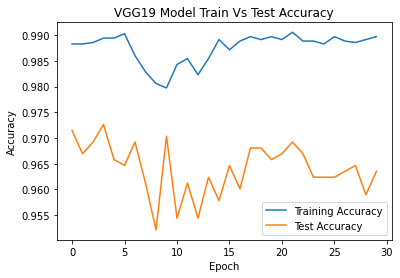

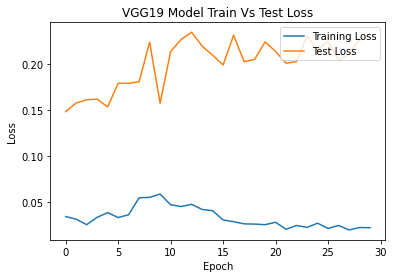

<Figure size 432x288 with 0 Axes>

In [41]:
predictions = final_model.predict(X_cv, batch_size = 64)
N = 30
plt.plot(np.arange(0, N), fitted_model.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.arange(0, N), fitted_model.history['val_accuracy'], label = "Test Accuracy")
plt.title('VGG19 Model Train Vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.show()
plt.savefig(r"C:\Users\suhas maddali\Desktop\Folders\Machine Learning Projects\Wheat Disease Detection\Wheat-Disease-Detection-\Plots\VGG19_accuracy_plots.png")

plt.plot(fitted_model.history['loss'], label = "Training Loss")
plt.plot(fitted_model.history['val_loss'], label = "Test Loss")
plt.title("VGG19 Model Train Vs Test Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper right')
plt.show()
plt.savefig(r"C:\Users\suhas maddali\Desktop\Folders\Machine Learning Projects\Wheat Disease Detection\Wheat-Disease-Detection-\Plots\VGG19_loss_plot.png")


In [48]:
import pickle 

In [59]:
model_file_path = "C:\Users\suhas maddali\Desktop\Folders\Machine Learning Projects\Wheat Disease Detection"

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (Temp/ipykernel_9628/3595446157.py, line 1)

In [47]:
pickle.dump(model, open(model_file_path, 'wb'))

NameError: name 'model_file_path' is not defined

In [45]:
with open('model_pkl', 'wb') as files:
    pickle.dump(final_model, files)

TypeError: cannot pickle '_thread.RLock' object

In [44]:
final_model.save("C:\Users\suhas maddali\Desktop\Folders\Machine Learning Projects\Wheat Disease Detection\Wheat-Disease-Detection-\VGG19_model.h5")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (Temp/ipykernel_9628/4249140376.py, line 1)

In [40]:
data = []
labels = []
for image_path in tqdm(paths.list_images(CROWN_AND_ROOT_ROT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    
for image_path in tqdm(paths.list_images(HEALTHY_AND_WHEAT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)

for image_path in tqdm(paths.list_images(LEAF_RUST_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    
for image_path in tqdm(paths.list_images(WHEAT_LOOSE_SMUT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    
    

1021it [00:04, 227.64it/s]
1146it [00:24, 46.33it/s] 
1286it [01:36, 13.31it/s] 
930it [00:04, 192.48it/s]


In [45]:
data = np.array(data)
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)


In [46]:
X_train, X_cv, y_train, y_cv = train_test_split(data, labels, test_size = 0.2,
                                                    stratify = labels, random_state = 101)

## Xception Network

It is now time to train an xception network to see how the training accuracy and the cross-validation accuracy increases with increase in the number of epochs.

As could be seen below from the architecture, the input shape that is accepted by Xception network is (299, 299, 3). Therefore, we did a good thing in the above cells in resizing the images to be of (299, 299) shape. 

In [50]:
headmodel = Xception(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (299, 299, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.2)(model)
model = Dense(len(Labels), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False

In [51]:
opt = Adam(lr = 1e-3)
final_model.compile(loss = "categorical_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

In [52]:
fitted_model = final_model.fit(X_train, y_train, validation_data = (X_cv, y_cv), 
               epochs = 30, batch_size = 64)

Epoch 1/30
55/55 [==============================] - 17s 305ms/step - loss: 14.1744 - accuracy: 0.4820 - val_loss: 1.1539 - val_accuracy: 0.5553
Epoch 2/30
55/55 [==============================] - 15s 280ms/step - loss: 0.9662 - accuracy: 0.6081 - val_loss: 0.8232 - val_accuracy: 0.6682
Epoch 3/30
55/55 [==============================] - 16s 283ms/step - loss: 0.7972 - accuracy: 0.6680 - val_loss: 0.7505 - val_accuracy: 0.6967
Epoch 4/30
55/55 [==============================] - 16s 286ms/step - loss: 0.7010 - accuracy: 0.7108 - val_loss: 0.6783 - val_accuracy: 0.7161
Epoch 5/30
55/55 [==============================] - 16s 288ms/step - loss: 0.5677 - accuracy: 0.7687 - val_loss: 0.5752 - val_accuracy: 0.7685
Epoch 6/30
55/55 [==============================] - 16s 297ms/step - loss: 0.4911 - accuracy: 0.8075 - val_loss: 0.5500 - val_accuracy: 0.8062
Epoch 7/30
55/55 [==============================] - 17s 312ms/step - loss: 0.4465 - accuracy: 0.8257 - val_loss: 0.5043 - val_accuracy: 0.821

## InceptionV3 Network

In the below cells, InceptionV3 network would be implemented with the weights taken from imagenet data. Inception weights are not trained and additional layers that are added on top of inception are trained to help us get the output for our prediction of disease in wheat. 

In [62]:
headmodel = InceptionV3(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (299, 299, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dense(256, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(len(Labels), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False

In [63]:
opt = Adam(lr = 1e-3)
final_model.compile(loss = "categorical_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

In [64]:
fitted_model = final_model.fit(X_train, y_train, validation_data = (X_cv, y_cv), 
               epochs = 30, batch_size = 64)

Epoch 1/30
55/55 [==============================] - 9s 172ms/step - loss: 7.3515 - accuracy: 0.3582 - val_loss: 1.5071 - val_accuracy: 0.4493
Epoch 2/30
55/55 [==============================] - 9s 157ms/step - loss: 1.2283 - accuracy: 0.5003 - val_loss: 1.1527 - val_accuracy: 0.5450
Epoch 3/30
55/55 [==============================] - 9s 168ms/step - loss: 1.0291 - accuracy: 0.5804 - val_loss: 1.1947 - val_accuracy: 0.5336
Epoch 4/30
55/55 [==============================] - 10s 188ms/step - loss: 0.9762 - accuracy: 0.6067 - val_loss: 1.0577 - val_accuracy: 0.5747
Epoch 5/30
55/55 [==============================] - 10s 173ms/step - loss: 0.9062 - accuracy: 0.6349 - val_loss: 1.0600 - val_accuracy: 0.5895
Epoch 6/30
55/55 [==============================] - 10s 180ms/step - loss: 0.8292 - accuracy: 0.6711 - val_loss: 1.0552 - val_accuracy: 0.6100
Epoch 7/30
55/55 [==============================] - 10s 183ms/step - loss: 0.7476 - accuracy: 0.7071 - val_loss: 0.8938 - val_accuracy: 0.6477
Ep

## ResNet152 Network

ResNet152 is used to check the performance of the models. Sometimes we are under the assumption that adding more layers in the neural network would reduce the training and test loss.

According to experiments, however, we see that adding more layers in our network would not decrease the training loss to a large extent.

Below is the implementation of ResNet152 Network. Feel free to take a look. 

In [65]:
headmodel = ResNet152(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (299, 299, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(len(Labels), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False

In [67]:
opt = Adam(lr = 1e-2)
final_model.compile(loss = "categorical_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

In [68]:
fitted_model = final_model.fit(X_train, y_train, validation_data = (X_cv, y_cv), 
               epochs = 30, batch_size = 64)

Epoch 1/30
55/55 [==============================] - 35s 636ms/step - loss: 15.4674 - accuracy: 0.6013 - val_loss: 0.5931 - val_accuracy: 0.8096
Epoch 2/30
55/55 [==============================] - 35s 632ms/step - loss: 0.4778 - accuracy: 0.8080 - val_loss: 0.3877 - val_accuracy: 0.8666
Epoch 3/30
55/55 [==============================] - 36s 659ms/step - loss: 0.3131 - accuracy: 0.8791 - val_loss: 0.2539 - val_accuracy: 0.9054
Epoch 4/30
55/55 [==============================] - 37s 680ms/step - loss: 0.2377 - accuracy: 0.9064 - val_loss: 0.2702 - val_accuracy: 0.9111
Epoch 5/30
55/55 [==============================] - 39s 708ms/step - loss: 0.1797 - accuracy: 0.9301 - val_loss: 0.1852 - val_accuracy: 0.9327
Epoch 6/30
55/55 [==============================] - 38s 687ms/step - loss: 0.1664 - accuracy: 0.9301 - val_loss: 0.1746 - val_accuracy: 0.9384
Epoch 7/30
55/55 [==============================] - 38s 687ms/step - loss: 0.1296 - accuracy: 0.9469 - val_loss: 0.1716 - val_accuracy: 0.937